In [ ]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [ ]:
# Data Transformations
train_transforms = transforms.Compose([transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       #transforms.RandomAffine(degrees=(-7.0, 7.0), translate=(0.1,0.1), scale=(0.9, 1.1), fill=(1,)),
                                       #transforms.ColorJitter(brightness=0.1, contrast=0.1),
                                       #transforms.RandomAdjustSharpness(1.1),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
SEED = 99

cuda = torch.cuda.is_available()

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

#data loader arguments - something you will fetch these from cmdt prompt
train_dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

test_dataloader_args = dict(shuffle=False, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=False, batch_size=64)

train_dataloader = torch.utils.data.DataLoader(train, **train_dataloader_args)
test_dataloader = torch.utils.data.DataLoader(test, **test_dataloader_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
torch.cuda.is_available()

True

In [ ]:
# # Statistics
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('Train Data Stats:')
# print('- Numpy Shape ', train.train_data.cpu().numpy().shape)
# print('- Tensor shape ', train.train_data.size())
# print('- Min ', torch.min(train_data))
# print('- Max ', torch.max(train_data))
# print('- mean ', torch.mean(train_data))
# print('- Std ', torch.std(train_data))
# print('- var ', torch.var(train_data))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([64, 1, 28, 28])
torch.Size([64])


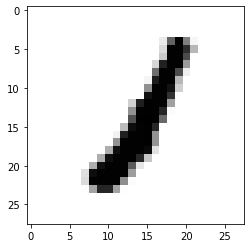

In [ ]:
# Print some images
diter = iter(train_dataloader)
images, labels = diter.next()

print(images.shape)
print(labels.shape)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

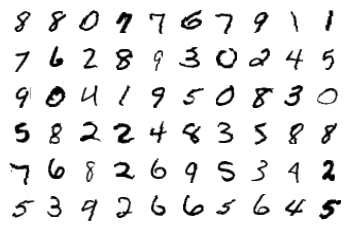

In [ ]:
figure = plt.figure()
num_images = 60
for index in range(1, num_images+1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model

In [ ]:
dropout_value = 0.01
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        # self.convblock5 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 8

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        #x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]             864
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.01)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_dataloader)

EPOCH: 0


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.3367919921875 Batch_id=937 Accuracy=94.50: 100%|██████████| 938/938 [00:27<00:00, 34.27it/s]



Test set: Average loss: 0.0442, Accuracy: 9854/10000 (98.54%)

EPOCH: 1


Loss=0.15287546813488007 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:26<00:00, 34.90it/s]



Test set: Average loss: 0.0404, Accuracy: 9865/10000 (98.65%)

EPOCH: 2


Loss=0.012495537288486958 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:27<00:00, 33.91it/s]



Test set: Average loss: 0.0331, Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Loss=0.18684116005897522 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:27<00:00, 34.06it/s]



Test set: Average loss: 0.0323, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.013744023628532887 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:27<00:00, 34.10it/s]



Test set: Average loss: 0.0285, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.0032465725671499968 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:27<00:00, 34.14it/s]



Test set: Average loss: 0.0251, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.002354638185352087 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:27<00:00, 34.41it/s]



Test set: Average loss: 0.0266, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.10300475358963013 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:28<00:00, 33.37it/s]



Test set: Average loss: 0.0264, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.05058911070227623 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:27<00:00, 33.60it/s]



Test set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.11698230355978012 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:27<00:00, 34.21it/s]



Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.12423091381788254 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:28<00:00, 33.42it/s]



Test set: Average loss: 0.0191, Accuracy: 9942/10000 (99.42%)

EPOCH: 11


Loss=0.005974482279270887 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:27<00:00, 33.75it/s]



Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.0011819230858236551 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:27<00:00, 33.96it/s]



Test set: Average loss: 0.0185, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.00420589093118906 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:27<00:00, 33.88it/s]



Test set: Average loss: 0.0187, Accuracy: 9944/10000 (99.44%)

EPOCH: 14


Loss=0.0006301548564806581 Batch_id=937 Accuracy=99.29: 100%|██████████| 938/938 [00:27<00:00, 34.29it/s]



Test set: Average loss: 0.0189, Accuracy: 9940/10000 (99.40%)



In [ ]:
import numpy as np
import  random

In [ ]:
def get_incorrect_preds(model, test_dataloader):
  incorrect_examples = []
  pred_wrong = []
  true_wrong = []

  model.eval()
  for data,target in test_dataloader:
    data , target = data.cuda(), target.cuda()
    output = model(data)
    _, preds = torch.max(output,1)
    preds = preds.cpu().numpy()
    target = target.cpu().numpy()
    preds = np.reshape(preds,(len(preds),1))
    target = np.reshape(target,(len(preds),1))
    data = data.cpu().numpy()
    for i in range(len(preds)):
        if(preds[i]!=target[i]):
            pred_wrong.append(preds[i])
            true_wrong.append(target[i])
            incorrect_examples.append(data[i])

  return true_wrong, incorrect_examples, pred_wrong

In [ ]:
def plot_incorrect_preds(true,ima,pred,n_figures = 10):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/5)
    fig,axes = plt.subplots(figsize=(14, 6), nrows = n_row, ncols=5)
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)
        image,correct,wrong = ima[a],true[a],pred[a]
        image = torch.from_numpy(image)
        correct = int(correct)
        wrong = int(wrong)
        image = image.squeeze().numpy()
        im = ax.imshow(image, cmap='gray_r')
        ax.set_title(f'A: {correct} , P: {wrong}')
        ax.axis('off')
    plt.show()

In [ ]:
true_wrong, incorrect_examples, pred_wrong = get_incorrect_preds(model, test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Classes in order Actual and Predicted


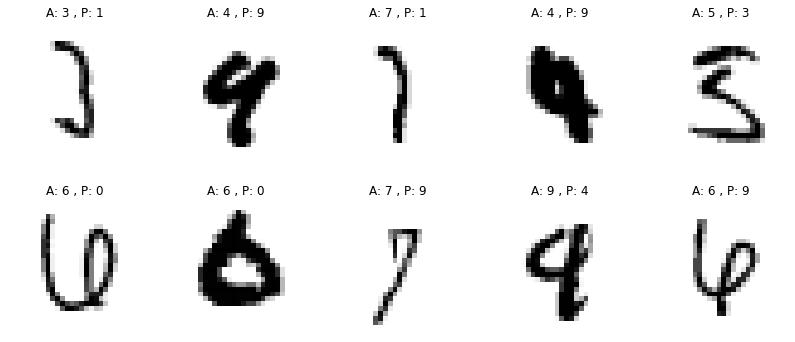

In [ ]:
plot_incorrect_preds(true_wrong, incorrect_examples, pred_wrong)

Text(0.5, 1.0, 'Test Accuracy')

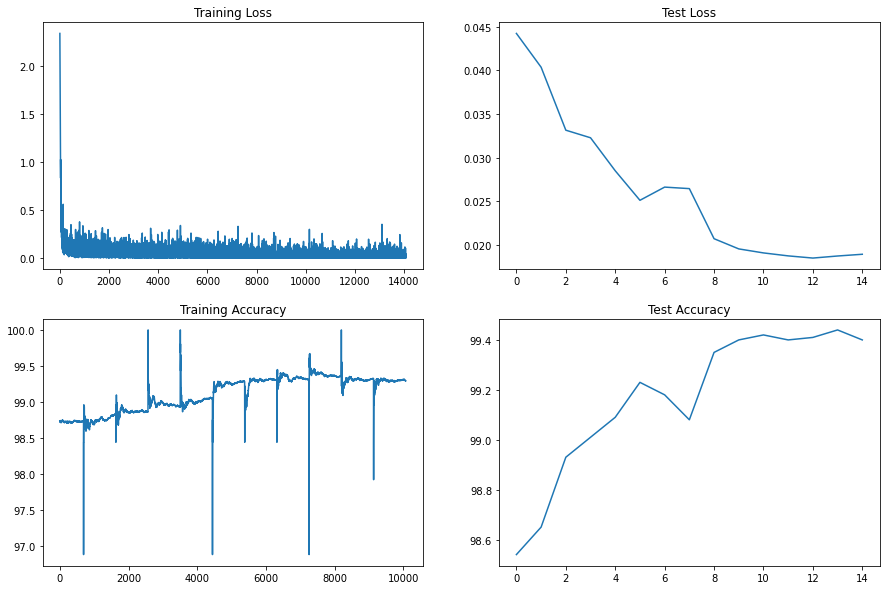

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")